In [18]:
from __future__ import annotations

import abc
import collections
import copy
import math
import random
import time
import typing

import numpy as np
import matplotlib.pyplot as plt
from river import base, metrics, stats, preprocessing, datasets
from river.drift import ADWIN, NoDrift
from river.tree.hoeffding_tree_classifier import HoeffdingTreeClassifier
from river.tree.hoeffding_tree_regressor import HoeffdingTreeRegressor
from river.tree.nodes.arf_htr_nodes import RandomLeafAdaptive, RandomLeafMean, RandomLeafModel
from river.tree.splitter import Splitter  # type: ignore
from river.utils.random import poisson

import logging
# Configure logging for more detailed output if desired
# logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


# ================================================================
# Base Classes
# ================================================================
class BaseForest(base.Ensemble):
    _FEATURES_SQRT = "sqrt"
    _FEATURES_LOG2 = "log2"

    def __init__(
        self,
        n_models: int,
        max_features: bool | str | int,
        lambda_value: int,
        drift_detector: base.DriftDetector,
        warning_detector: base.DriftDetector,
        metric: metrics.base.MultiClassMetric | metrics.base.RegressionMetric,
        disable_weighted_vote: bool,
        seed: int | None,
    ):
        # Calls collections.UserList.__init__ via base.Ensemble's MRO,
        # effectively self.data = []. This bypasses river.base.Ensemble's __init__ logic
        # that performs the _min_number_of_models check on the passed models list.
        super(base.Ensemble, self).__init__([])

        # Initialize BaseForest specific attributes
        self.n_models = n_models # This is the target/initial number of models for _init_ensemble
        self.max_features = max_features
        self.lambda_value = lambda_value
        self.metric = metric
        self.disable_weighted_vote = disable_weighted_vote
        self.drift_detector = drift_detector
        self.warning_detector = warning_detector
        self.seed = seed
        self._rng = random.Random(self.seed)

        self._warning_detectors: list[base.DriftDetector] = []
        self._warning_detection_disabled = isinstance(self.warning_detector, NoDrift)

        self._drift_detectors: list[base.DriftDetector] = []
        self._drift_detection_disabled = isinstance(self.drift_detector, NoDrift)

        self._background: list[HoeffdingTreeClassifier | HoeffdingTreeRegressor | None] = []
        self._metrics: list[metrics.base.Metric] = []

        self._warning_tracker: dict[int, int] = collections.defaultdict(int) if not self._warning_detection_disabled else {}
        self._drift_tracker: dict[int, int] = collections.defaultdict(int) if not self._drift_detection_disabled else {}
        # Models are added via _init_ensemble, typically called on first learn/predict

    @property
    def _min_number_of_models(self) -> int:
        # This is the fallback minimum if a subclass doesn't override it.
        # SmartARFRegressor will override this with its specific minimum.
        return 1

    @abc.abstractmethod
    def _drift_detector_input(self, tree_id: int, y_true, y_pred) -> int | float:
        raise NotImplementedError

    @abc.abstractmethod
    def _new_base_model(self) -> HoeffdingTreeClassifier | HoeffdingTreeRegressor:
        raise NotImplementedError

    def _init_ensemble(self, features: list):
        # print(f"DEBUG: _init_ensemble called with {len(features)} features. n_models={self.n_models}") # DEBUG
        self._set_max_features(len(features))
        self.data.clear()
        self._metrics.clear()
        self._warning_detectors.clear()
        self._drift_detectors.clear()
        self._background.clear()

        if hasattr(self, '_drift_norm') and isinstance(getattr(self, '_drift_norm'), list):
            getattr(self, '_drift_norm').clear()
        if hasattr(self, '_accuracy_window') and isinstance(getattr(self, '_accuracy_window'), list):
            getattr(self, '_accuracy_window').clear()


        # self.n_models here refers to the initial/target number of models for this ensemble type
        for i in range(self.n_models):
            # print(f"DEBUG: Initializing model {i+1}/{self.n_models}") # DEBUG
            self.append(self._new_base_model()) # self.append is from UserList via Ensemble

        count = len(self.data)
        if not self._warning_detection_disabled:
            self._warning_detectors = [self.warning_detector.clone() for _ in range(count)]
            self._background = [None] * count
        if not self._drift_detection_disabled:
            self._drift_detectors = [self.drift_detector.clone() for _ in range(count)]
        self._metrics = [self.metric.clone() for _ in range(count)]

        if hasattr(self, '_init_drift_norm') and callable(getattr(self, '_init_drift_norm', None)):
            self._init_drift_norm() # type: ignore
        if hasattr(self, '_init_pruning_state') and callable(getattr(self, '_init_pruning_state', None)):
            self._init_pruning_state() # type: ignore

        self._warning_tracker.clear()
        self._drift_tracker.clear()
        # print(f"DEBUG: _init_ensemble finished. Ensemble size: {len(self.data)}") # DEBUG


    def _set_max_features(self, n_features: int):
        orig = self.max_features
        if self.max_features == self._FEATURES_SQRT:
            self.max_features = round(math.sqrt(n_features))
        elif self.max_features == self._FEATURES_LOG2:
            self.max_features = round(math.log2(n_features))
        elif isinstance(self.max_features, float): # type: ignore
            self.max_features = int(self.max_features * n_features)
        elif self.max_features is None:
            self.max_features = n_features
        elif not isinstance(self.max_features, int):
             raise AttributeError(f"Invalid max_features: {orig}")

        if self.max_features < 0 :
            self.max_features += n_features
        self.max_features = max(1, min(self.max_features, n_features)) # type: ignore

    def n_warnings_detected(self, tree_id: int | None = None) -> int:
        if self._warning_detection_disabled:
            return 0
        if tree_id is None:
            return sum(self._warning_tracker.values())
        return self._warning_tracker.get(tree_id, 0)

    def n_drifts_detected(self, tree_id: int | None = None) -> int:
        if self._drift_detection_disabled:
            return 0
        if tree_id is None:
            return sum(self._drift_tracker.values())
        return self._drift_tracker.get(tree_id, 0)


class BaseTreeRegressor(HoeffdingTreeRegressor):
    def __init__(
        self,
        max_features: int = 2,
        grace_period: int = 200,
        max_depth: int | None = None,
        delta: float = 1e-7,
        tau: float = 0.05,
        leaf_prediction: str = "adaptive",
        leaf_model: base.Regressor | None = None,
        model_selector_decay: float = 0.95,
        nominal_attributes: list | None = None,
        splitter: Splitter | None = None,
        min_samples_split: int = 5,
        binary_split: bool = False,
        max_size: float = 100.0,
        memory_estimate_period: int = 1000000,
        stop_mem_management: bool = False,
        remove_poor_attrs: bool = False,
        merit_preprune: bool = True,
        rng: random.Random | None = None,
    ):
        super().__init__(
            grace_period=grace_period,
            max_depth=max_depth,
            delta=delta,
            tau=tau,
            leaf_prediction=leaf_prediction,
            leaf_model=leaf_model,
            model_selector_decay=model_selector_decay,
            nominal_attributes=nominal_attributes,
            splitter=splitter,
            min_samples_split=min_samples_split,
            binary_split=binary_split,
            max_size=max_size,
            memory_estimate_period=memory_estimate_period,
            stop_mem_management=stop_mem_management,
            remove_poor_attrs=remove_poor_attrs,
            merit_preprune=merit_preprune,
        )
        self.max_features = max_features
        self.rng = rng if rng is not None else random.Random()

    def _new_leaf(self, initial_stats=None, parent=None):
        depth = parent.depth + 1 if parent else 0
        leaf_model = None
        if self.leaf_prediction in {self._MODEL, self._ADAPTIVE}:
            if parent and hasattr(parent, '_leaf_model') and parent._leaf_model is not None:
                leaf_model = copy.deepcopy(parent._leaf_model)
            elif self.leaf_model is not None:
                leaf_model = copy.deepcopy(self.leaf_model)

        if self.leaf_prediction == self._TARGET_MEAN:
            return RandomLeafMean(initial_stats, depth, self.splitter, self.max_features, self.rng)
        elif self.leaf_prediction == self._MODEL:
            return RandomLeafModel(
                initial_stats, depth, self.splitter, self.max_features, self.rng, leaf_model=leaf_model
            )
        else:
            adaptive = RandomLeafAdaptive(
                initial_stats, depth, self.splitter, self.max_features, self.rng, leaf_model=leaf_model
            )
            if isinstance(parent, RandomLeafAdaptive):
                adaptive._fmse_mean = parent._fmse_mean
                adaptive._fmse_model = parent._fmse_model
            return adaptive

class ARFRegressor(BaseForest, base.Regressor):
    _MEAN = "mean"
    _MEDIAN = "median"

    def __init__(
        self,
        n_models: int = 10,
        max_features="sqrt",
        aggregation_method: str = "mean",
        lambda_value: int = 6,
        metric: metrics.base.RegressionMetric | None = None,
        disable_weighted_vote: bool = True,
        drift_detector: base.DriftDetector | None = None,
        warning_detector: base.DriftDetector | None = None,
        grace_period: int = 50,
        max_depth: int | None = None,
        delta: float = 0.01,
        tau: float = 0.05,
        leaf_prediction: str = "adaptive",
        leaf_model: base.Regressor | None = None,
        model_selector_decay: float = 0.95,
        nominal_attributes: list | None = None,
        splitter: Splitter | None = None,
        min_samples_split: int = 5,
        binary_split: bool = False,
        max_size: float = 500.0,
        memory_estimate_period: int = 2_000_000,
        stop_mem_management: bool = False,
        remove_poor_attrs: bool = False,
        merit_preprune: bool = True,
        seed: int | None = None,
    ):
        super().__init__( # This now calls the modified BaseForest.__init__
            n_models=n_models,
            max_features=max_features,
            lambda_value=lambda_value,
            metric=metric if metric is not None else metrics.MSE(),
            disable_weighted_vote=disable_weighted_vote,
            drift_detector=drift_detector if drift_detector is not None else ADWIN(0.001),
            warning_detector=warning_detector if warning_detector is not None else ADWIN(0.01),
            seed=seed,
        )
        self.grace_period = grace_period
        self.max_depth = max_depth
        self.delta = delta
        self.tau = tau
        self.leaf_prediction = leaf_prediction
        self.leaf_model = leaf_model
        self.model_selector_decay = model_selector_decay
        self.nominal_attributes = nominal_attributes
        self.splitter = splitter
        self.min_samples_split = min_samples_split
        self.binary_split = binary_split
        self.max_size = max_size
        self.memory_estimate_period = memory_estimate_period
        self.stop_mem_management = stop_mem_management
        self.remove_poor_attrs = remove_poor_attrs
        self.merit_preprune = merit_preprune

        if aggregation_method not in {self._MEAN, self._MEDIAN}:
            raise ValueError(f"Invalid aggregation_method: {aggregation_method}")
        self.aggregation_method = aggregation_method
        self._drift_norm: list[stats.Var] = []

    def _init_drift_norm(self):
        self._drift_norm = [stats.Var() for _ in range(len(self.data))]

    @property
    def _mutable_attributes(self):
        return {"max_features", "aggregation_method", "lambda_value",
                "grace_period", "max_depth", "delta", "tau", "leaf_prediction",
                "leaf_model", "model_selector_decay", "nominal_attributes",
                "splitter", "min_samples_split", "binary_split", "max_size",
                "memory_estimate_period", "stop_mem_management",
                "remove_poor_attrs", "merit_preprune"}

    def _new_base_model(self) -> BaseTreeRegressor:
        return BaseTreeRegressor(
            max_features=self.max_features, # type: ignore
            grace_period=self.grace_period,
            max_depth=self.max_depth,
            delta=self.delta,
            tau=self.tau,
            leaf_prediction=self.leaf_prediction,
            leaf_model=self.leaf_model,
            model_selector_decay=self.model_selector_decay,
            nominal_attributes=self.nominal_attributes,
            splitter=self.splitter,
            min_samples_split=self.min_samples_split,
            binary_split=self.binary_split,
            max_size=self.max_size,
            memory_estimate_period=self.memory_estimate_period,
            stop_mem_management=self.stop_mem_management,
            remove_poor_attrs=self.remove_poor_attrs,
            merit_preprune=self.merit_preprune,
            rng=self._rng,
        )

    def _drift_detector_input(
        self, tree_id: int, y_true: base.typing.Target, y_pred: base.typing.RegTarget # type: ignore
    ) -> float:
        y_t = float(y_true)
        y_p = float(y_pred)
        error = y_t - y_p
        if tree_id >= len(self._drift_norm):
            return 0.5
        self._drift_norm[tree_id].update(error)

        if self._drift_norm[tree_id].mean.n <= 1: # type: ignore
            return 0.5

        variance = self._drift_norm[tree_id].get()
        if variance < 1e-9:
             return 0.0 if abs(error) < 1e-9 else 1.0

        sd = math.sqrt(variance)
        normalized_error = abs(error / (3 * sd)) if sd > 0 else (1.0 if error != 0 else 0.0)
        return min(1.0, max(0.0, normalized_error))

    def _add_new_model_to_ensemble(self, new_model: BaseTreeRegressor):
        self.append(new_model)
        self._metrics.append(self.metric.clone())
        if not self._drift_detection_disabled:
            self._drift_detectors.append(self.drift_detector.clone())
        if not self._warning_detection_disabled:
            self._warning_detectors.append(self.warning_detector.clone())
            self._background.append(None)
        self._drift_norm.append(stats.Var())

    def learn_one(self, x: dict, y: base.typing.Target, **kwargs): # type: ignore
        if not self:
            self._init_ensemble(sorted(x.keys()))

        for i in range(len(self.data)):
            model = self.data[i]
            y_pred = model.predict_one(x)
            self._metrics[i].update(y, y_pred) # type: ignore
            k = poisson(self.lambda_value, rng=self._rng)
            if k <= 0:
                continue

            if not self._warning_detection_disabled and self._background[i] is not None:
                self._background[i].learn_one(x, y, w=k) # type: ignore

            if not self._warning_detection_disabled:
                wd_input = self._drift_detector_input(i, y, y_pred)
                self._warning_detectors[i].update(wd_input)
                if self._warning_detectors[i].drift_detected:
                    if self._background[i] is None:
                        self._background[i] = self._new_base_model()
                    self._warning_detectors[i] = self.warning_detector.clone()
                    self._warning_tracker[i] += 1

            if not self._drift_detection_disabled:
                dd_input = self._drift_detector_input(i, y, y_pred)
                self._drift_detectors[i].update(dd_input)
                if self._drift_detectors[i].drift_detected:
                    self._drift_tracker[i] += 1
                    current_background_learner = self._background[i]

                    if current_background_learner is not None:
                        self.data[i] = current_background_learner
                        self._background[i] = self._new_base_model()
                    else:
                        self.data[i] = self._new_base_model()
                        self._background[i] = None

                    self._metrics[i] = self.metric.clone()
                    self._drift_detectors[i] = self.drift_detector.clone()
                    if not self._warning_detection_disabled:
                         self._warning_detectors[i] = self.warning_detector.clone()
                    self._drift_norm[i] = stats.Var()
                    self._warning_tracker[i] = 0
            model.learn_one(x, y, w=k)
        return self

    def predict_one(self, x: dict) -> base.typing.RegTarget:
        if not self:
            self._init_ensemble(sorted(x.keys()))

        if not self.data:
            return 0.0

        preds = np.array([m.predict_one(x) for m in self.data if m is not None])
        if preds.size == 0:
            if self.n_models > 0 :
                pass
            return 0.0

        if self.aggregation_method == self._MEDIAN:
            return float(np.median(preds))

        if self.disable_weighted_vote or len(self.data) <= 1: # type: ignore
            return float(np.mean(preds))
        else:
            weights = []
            valid_preds = []
            for idx in range(len(self.data)):
                if idx >= len(preds) or idx >= len(self._metrics):
                    continue
                pred_val = preds[idx]
                metric_obj = self._metrics[idx]
                try:
                    metric_val = metric_obj.get()
                    if not (math.isnan(metric_val) or math.isinf(metric_val)):
                        weights.append(metric_val)
                        valid_preds.append(pred_val)
                except Exception:
                    pass

            if not weights or not valid_preds:
                return float(np.mean(preds))

            weights_arr = np.array(weights)
            valid_preds_arr = np.array(valid_preds)

            if not self.metric.bigger_is_better: # type: ignore
                max_val = np.max(weights_arr)
                if max_val > 1e-9:
                    weights_arr = max_val - weights_arr
                else:
                    weights_arr = np.ones_like(weights_arr)

            sum_weights = np.sum(weights_arr)
            if sum_weights <= 1e-9:
                return float(np.mean(valid_preds_arr))
            return float(np.dot(valid_preds_arr, weights_arr) / sum_weights)

class SmartARFRegressor(ARFRegressor):
    def __init__(
        self,
        n_models: int = 10,
        max_models: int = 30,
        regression_pruning_error_threshold: float = 0.1,
        accuracy_drop_threshold: float = 0.5,
        monitor_window: int = 100,
        disable_weighted_vote: bool = False,
        verbose_logging: bool = False,
        min_ensemble_size: int = 5, # Default minimum size
        **kwargs
    ):
        # Ensure n_models used for initialization is at least min_ensemble_size
        effective_n_models = max(n_models, min_ensemble_size)

        super().__init__(n_models=effective_n_models, # ARFRegressor gets effective_n_models
                         disable_weighted_vote=disable_weighted_vote,
                         **kwargs) # Pass other ARF params to ARFRegressor -> BaseForest

        self.max_models = max_models
        # self.n_models inherited from ARFRegressor will be effective_n_models
        self.regression_pruning_error_threshold = regression_pruning_error_threshold
        self.accuracy_drop_threshold = accuracy_drop_threshold
        self.monitor_window = monitor_window
        self.verbose_logging = verbose_logging
        self.min_ensemble_size = min_ensemble_size # Store the desired minimum

        self.model_count_history: list[int] = []
        self._accuracy_window: list[collections.deque] = []
        self._warned_tree_ids: set[int] = set()
        self._warning_step: dict[int, int] = {}
        self._warned_recent_acc: dict[int, float] = {}
        self._n_samples_seen = 0
        # Initial log after all super inits have run
        # self._log(f"SmartARF initialized. Effective n_models={self.n_models}, max_models={self.max_models}, min_ensemble_size={self.min_ensemble_size}")


    @property
    def _min_number_of_models(self) -> int:
        """Defines the minimum number of models SmartARF tries to maintain."""
        return self.min_ensemble_size


    def _log(self, message: str):
        if self.verbose_logging:
            # Ensure _n_samples_seen is available, might not be if called from __init__ super chain early
            step_info = getattr(self, '_n_samples_seen', 'init')
            print(f"[SmartARF Step {step_info}] {message}")

    def _init_pruning_state(self): # Called by BaseForest._init_ensemble
        count = len(self.data) # self.data is populated by BaseForest._init_ensemble calling self.append
        self._accuracy_window = [collections.deque(maxlen=self.monitor_window) for _ in range(count)]
        self._warned_tree_ids.clear()
        self._warning_step.clear()
        self._warned_recent_acc.clear()

    def _add_new_model_to_ensemble(self, new_model: BaseTreeRegressor):
        self._log(f"Adding new model. Ensemble size before: {len(self.data)}")
        super()._add_new_model_to_ensemble(new_model) # ARFRegressor's method
        self._accuracy_window.append(collections.deque(maxlen=self.monitor_window))
        self._log(f"Model added. Ensemble size after: {len(self.data)}")

    def _remove_model(self, index_to_remove: int):
        if not (0 <= index_to_remove < len(self.data)):
            return
        self._log(f"Removing model at index {index_to_remove}. Ensemble size before: {len(self.data)}")
        
        # self.pop is from river.base.Ensemble (UserList)
        # No need to call super(ARFRegressor, self).pop or similar explicitly
        self.pop(index_to_remove)


        lists_to_prune_attrs = [
            '_metrics', '_drift_detectors', '_warning_detectors',
            '_background', '_drift_norm', '_accuracy_window'
        ]
        for attr_name in lists_to_prune_attrs:
            lst = getattr(self, attr_name)
            if index_to_remove < len(lst):
                lst.pop(index_to_remove)

        new_warned_tree_ids = set()
        for warned_idx in self._warned_tree_ids:
            if warned_idx == index_to_remove:
                continue
            elif warned_idx > index_to_remove:
                new_warned_tree_ids.add(warned_idx - 1)
            else:
                new_warned_tree_ids.add(warned_idx)
        self._warned_tree_ids = new_warned_tree_ids

        new_warning_step = {}
        for warned_idx, step_val in self._warning_step.items():
            if warned_idx == index_to_remove:
                continue
            elif warned_idx > index_to_remove:
                new_warning_step[warned_idx - 1] = step_val
            else:
                new_warning_step[warned_idx] = step_val
        self._warning_step = new_warning_step

        new_warned_recent_acc = {}
        for warned_idx, acc_val in self._warned_recent_acc.items():
            if warned_idx == index_to_remove:
                continue
            elif warned_idx > index_to_remove:
                new_warned_recent_acc[warned_idx - 1] = acc_val
            else:
                new_warned_recent_acc[warned_idx] = acc_val
        self._warned_recent_acc = new_warned_recent_acc
        self._log(f"Model removed. Ensemble size after: {len(self.data)}")


    def learn_one(self, x: dict, y: base.typing.Target, **kwargs): # type: ignore
        if not self: # if self.data is empty
            self._init_ensemble(sorted(x.keys()))

        self._n_samples_seen += 1
        step = self._n_samples_seen
        self.model_count_history.append(len(self.data))
        if self._n_samples_seen == 1: # Log initial state after first learn one call
             self._log(f"First learn_one. Effective n_models={self.n_models}, max_models={self.max_models}, min_ensemble_size={self.min_ensemble_size}")
        self._log(f"Start learn_one. Current ensemble size: {len(self.data)}")


        drift_indices = []
        warning_indices = []

        # Stage 1
        for i in range(len(self.data)):
            if i >= len(self.data) or self.data[i] is None: continue
            if i >= len(self._metrics): continue

            model = self.data[i]
            pred = model.predict_one(x)
            self._metrics[i].update(y, pred) # type: ignore
            acc_flag = 1 if abs(float(y) - float(pred)) <= self.regression_pruning_error_threshold else 0
            if i < len(self._accuracy_window):
                 self._accuracy_window[i].append(acc_flag)

            if not self._warning_detection_disabled:
                if i >= len(self._warning_detectors): continue
                wd_input = self._drift_detector_input(i, y, pred)
                self._warning_detectors[i].update(wd_input)
                if self._warning_detectors[i].drift_detected:
                    self._log(f"Warning detected for model {i}.")
                    warning_indices.append(i)

            if not self._drift_detection_disabled:
                if i >= len(self._drift_detectors): continue
                dd_input = self._drift_detector_input(i, y, pred)
                self._drift_detectors[i].update(dd_input)
                if self._drift_detectors[i].drift_detected:
                    self._log(f"Drift detected for model {i}.")
                    drift_indices.append(i)

        # Stage 2
        for i in warning_indices:
            if i >= len(self._background) or i >= len(self._warning_detectors) : continue
            if self._background[i] is None:
                self._log(f"Creating background learner for warned model {i}.")
                self._background[i] = self._new_base_model()
            self._warning_detectors[i] = self.warning_detector.clone()
            self._warning_tracker[i] += 1
            if i not in self._warned_tree_ids:
                self._warned_tree_ids.add(i)
                self._warning_step[i] = step
                if i < len(self._accuracy_window) and len(self._accuracy_window[i]) >= self.monitor_window:
                    past_acc = sum(self._accuracy_window[i]) / len(self._accuracy_window[i])
                    self._warned_recent_acc[i] = past_acc
                    self._log(f"Model {i} warned. Storing past accuracy: {past_acc:.3f} over {len(self._accuracy_window[i])} samples.")
                else:
                    self._warned_recent_acc[i] = 1.0 # Default if not enough data
                    self._log(f"Model {i} warned. Not enough samples ({len(self._accuracy_window[i]) if i < len(self._accuracy_window) else 'N/A'}) for past accuracy, defaulting to 1.0.")


        # Stage 3
        background_models_to_add = []
        drifted_indices_processed_for_reset = set()

        for i in sorted(list(set(drift_indices))):
            if i >= len(self.data): continue
            if i in drifted_indices_processed_for_reset: continue

            self._log(f"Processing drift for model {i}. Current bg: {'Exists' if i < len(self._background) and self._background[i] else 'None'}")
            self._drift_tracker[i] += 1
            if i < len(self._background) and self._background[i]:
                self._log(f"Marking background model from slot {i} to be added.")
                background_models_to_add.append(self._background[i])
                self._background[i] = None

            self._log(f"Resetting drifted model {i}.")
            self.data[i] = self._new_base_model()
            if i < len(self._metrics): self._metrics[i] = self.metric.clone()
            if i < len(self._drift_detectors): self._drift_detectors[i] = self.drift_detector.clone()
            if not self._warning_detection_disabled and i < len(self._warning_detectors):
                self._warning_detectors[i] = self.warning_detector.clone()
            if i < len(self._drift_norm): self._drift_norm[i] = stats.Var()
            if i < len(self._accuracy_window): self._accuracy_window[i].clear()

            if i in self._warned_tree_ids:
                self._warned_tree_ids.discard(i)
                self._warning_step.pop(i, None)
                self._warned_recent_acc.pop(i, None)
            drifted_indices_processed_for_reset.add(i)

        for bg_model_candidate in background_models_to_add:
            if len(self.data) < self.max_models:
                self._log(f"Adding promoted background model. Ensemble size < max_models ({len(self.data)} < {self.max_models}).")
                self._add_new_model_to_ensemble(bg_model_candidate)
            else:
                self._log(f"Ensemble at max_models ({self.max_models}). Finding worst model to replace for promoted BG.")
                worst_model_idx = self._find_worst_model()
                if worst_model_idx is not None:
                    self._log(f"Worst model is {worst_model_idx}. Removing it to make space.")
                    self._remove_model(worst_model_idx) # This might make len(self.data) < max_models
                    self._log(f"Adding promoted background model after removing worst.")
                    self._add_new_model_to_ensemble(bg_model_candidate)
                else:
                    self._log("Could not find a worst model to replace, promoted background model not added.")

        while len(self.data) > self.max_models:
            self._log(f"Ensemble size ({len(self.data)}) > max_models ({self.max_models}). Pruning worst.")
            worst_model_idx = self._find_worst_model()
            # Also check if we are already at or below the defined minimum
            if worst_model_idx is not None and len(self.data) > self._min_number_of_models:
                self._remove_model(worst_model_idx)
            else:
                self._log(f"Cannot prune further (no worst found or at/below min models {self._min_number_of_models}).")
                break

        # Stage 4
        indices_to_remove_due_to_acc_drop = []
        current_warned_ids = list(self._warned_tree_ids)
        for i in current_warned_ids:
            if not (0 <= i < len(self.data)):
                self._warned_tree_ids.discard(i)
                self._warning_step.pop(i, None)
                self._warned_recent_acc.pop(i, None)
                continue

            age_since_warning = step - self._warning_step.get(i, step)
            if i >= len(self._accuracy_window): continue
            current_acc_window = self._accuracy_window[i]

            if len(current_acc_window) < self.monitor_window:
                if age_since_warning > 2 * self.monitor_window:
                    self._log(f"Warned model {i} has insufficient data for acc drop check for too long. Clearing warning state.")
                    self._warned_tree_ids.discard(i)
                    self._warning_step.pop(i, None)
                    self._warned_recent_acc.pop(i, None)
                continue

            current_accuracy = sum(current_acc_window) / len(current_acc_window)
            accuracy_at_warning_time = self._warned_recent_acc.get(i, 1.0)
            self._log(f"AccDropCheck for warned model {i}: Age {age_since_warning}, CurrentAcc {current_accuracy:.3f} (win {len(current_acc_window)}), PastAcc {accuracy_at_warning_time:.3f}, Thr {self.accuracy_drop_threshold * accuracy_at_warning_time:.3f}")

            if accuracy_at_warning_time > 1e-6 and \
               current_accuracy < (self.accuracy_drop_threshold * accuracy_at_warning_time):
                self._log(f"Sustained accuracy drop for model {i}. Marking for removal.")
                indices_to_remove_due_to_acc_drop.append(i)

        for i in sorted(indices_to_remove_due_to_acc_drop, reverse=True):
            if len(self.data) > self._min_number_of_models: # Use the property here
                self._log(f"Pruning model {i} due to accuracy drop.")
                self._remove_model(i)
            else:
                self._log(f"Skipping pruning model {i} (accuracy drop) because at min models ({self._min_number_of_models}).")

        # Stage 5
        for i in range(len(self.data)):
            if i >= len(self.data) or self.data[i] is None : continue
            k = poisson(self.lambda_value, rng=self._rng)
            if k <= 0: continue
            if not self._warning_detection_disabled:
                if i < len(self._background) and self._background[i] is not None:
                    self._background[i].learn_one(x, y, w=k) # type: ignore
            if i < len(self.data) and self.data[i] is not None:
                 self.data[i].learn_one(x, y, w=k)
        self._log(f"End learn_one. Final ensemble size: {len(self.data)}")
        return self

    def _find_worst_model(self) -> int | None:
        if not self.data or not self._metrics:
            return None
        valid_metrics = []
        valid_indices = []
        for i in range(min(len(self.data), len(self._metrics))):
            metric_obj = self._metrics[i]
            try:
                val = metric_obj.get()
                if not (math.isnan(val) or math.isinf(val)):
                    valid_metrics.append(val)
                    valid_indices.append(i)
            except Exception:
                pass
        if not valid_metrics:
            return None if not self.data else random.randrange(len(self.data)) if self.data else None

        if self.metric.bigger_is_better: # type: ignore
            worst_idx_in_valids = np.argmin(valid_metrics)
        else:
            worst_idx_in_valids = np.argmax(valid_metrics)
        return valid_indices[worst_idx_in_valids]

    def plot_model_count(self):
        if not self.model_count_history:
            print("No model count history to plot for SmartARFRegressor.")
            return
        plt.figure(figsize=(10, 6))
        plt.plot(self.model_count_history, drawstyle="steps-post", label="Actual Ensemble Size")
        plt.axhline(self.max_models, color='r', linestyle='--', label=f"Max Models ({self.max_models})")
        plt.axhline(self.n_models, color='g', linestyle=':', label=f"Initial/Target Models ({self.n_models})") # self.n_models is effective_n_models
        # Use the _min_number_of_models property which reflects self.min_ensemble_size
        if self._min_number_of_models > 0 :
             plt.axhline(self._min_number_of_models, color='b', linestyle=':', label=f"Min Ensemble Size ({self._min_number_of_models})")
        plt.xlabel("Instances Processed (Learn One Calls)")
        plt.ylabel("Number of Models in Ensemble")
        plt.title("SmartARFRegressor Ensemble Size Over Time")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

▶️  Evaluating Standard ARF (Fixed Size Implementation)…
  Standard ARF - Step 10000, MAE: 2.0656, Num Models: 10, Drifts: 0
Standard ARF evaluation time: 25.07 seconds

▶️  Evaluating SmartARFRegressor…
[SmartARF Step 1] First learn_one. Effective n_models=10, max_models=20, min_ensemble_size=5
[SmartARF Step 1] Start learn_one. Current ensemble size: 10
[SmartARF Step 1] End learn_one. Final ensemble size: 10
[SmartARF Step 2] Start learn_one. Current ensemble size: 10
[SmartARF Step 2] End learn_one. Final ensemble size: 10
[SmartARF Step 3] Start learn_one. Current ensemble size: 10
[SmartARF Step 3] End learn_one. Final ensemble size: 10
[SmartARF Step 4] Start learn_one. Current ensemble size: 10
[SmartARF Step 4] End learn_one. Final ensemble size: 10
[SmartARF Step 5] Start learn_one. Current ensemble size: 10
[SmartARF Step 5] End learn_one. Final ensemble size: 10
[SmartARF Step 6] Start learn_one. Current ensemble size: 10
[SmartARF Step 6] End learn_one. Final ensemble size

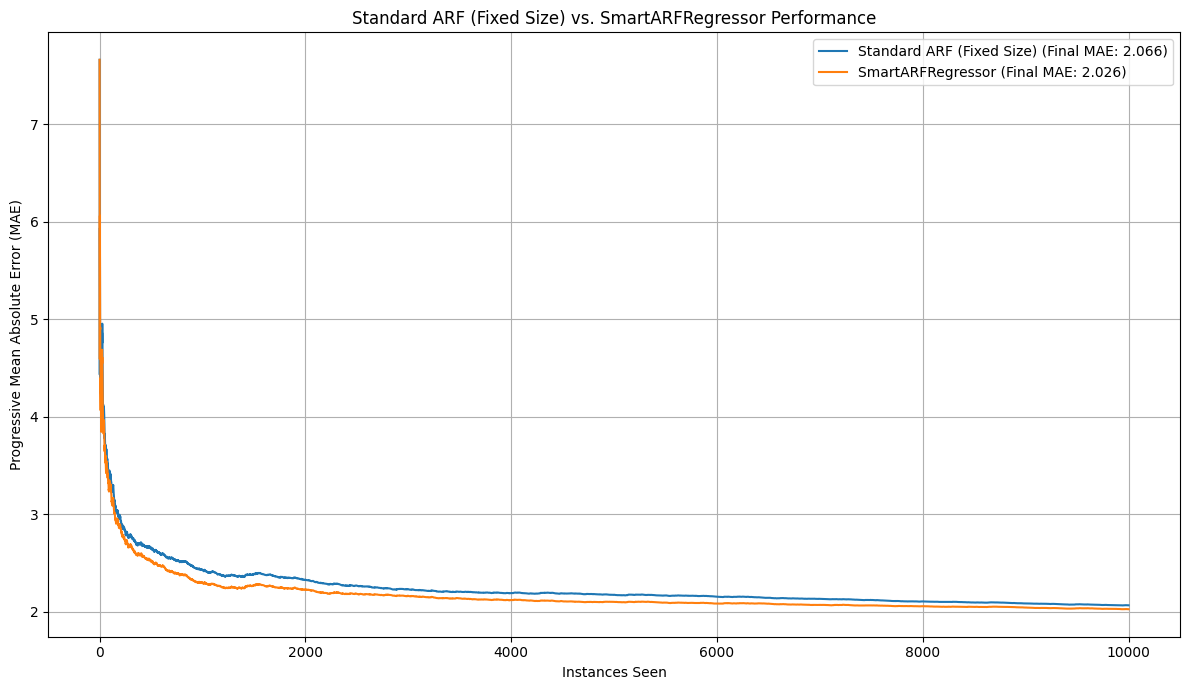


▶️  Plotting SmartARFRegressor Ensemble Size Over Time...


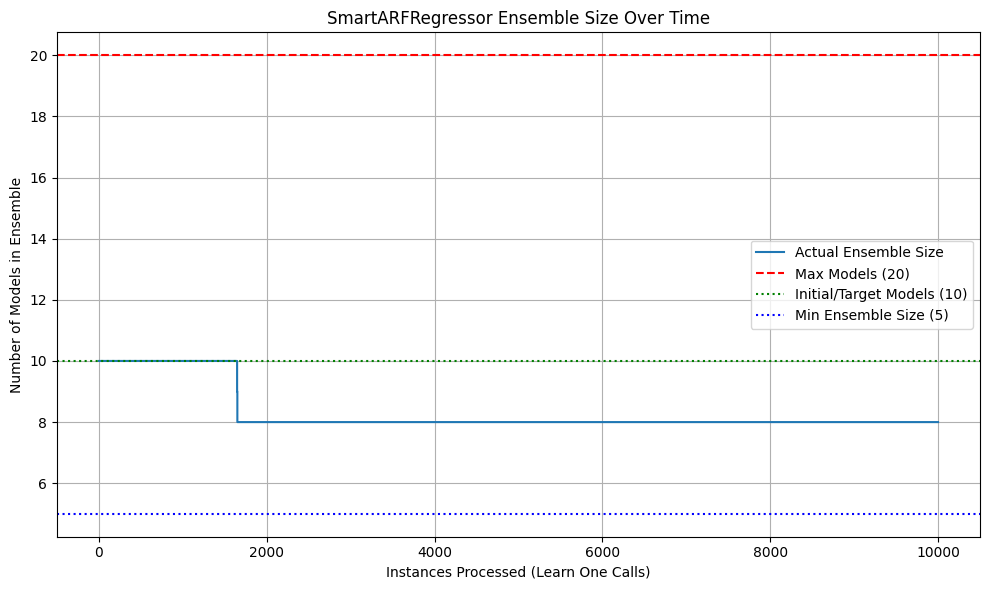


Standard ARF (Fixed Size) final number of models: 10


In [19]:
from river import datasets
from river import preprocessing
from itertools import tee
import time
import matplotlib.pyplot as plt
import logging # Ensure logging is imported
from river.forest import ARFRegressor

# (The ARFRegressor and SmartARFRegressor class definitions should be available here)

# 1. Create the dataset stream and copy it
dataset_generator = datasets.synth.FriedmanDrift(seed=42, position=(500,1000,10000)) # Add some drift
dataset = dataset_generator.take(10000) # Use 100k instances to see more drift effects
stream_standard, stream_smart = tee(dataset)

# 2. Define the models
N_MODELS_INITIAL = 10

model_standard_pipeline = ARFRegressor(
        n_models=N_MODELS_INITIAL,
        seed=42,
        lambda_value=6,
        grace_period=50,
        leaf_prediction="adaptive",
        metric=metrics.MAE(),
        drift_detector=ADWIN(delta=0.001), # More sensitive drift for standard
        warning_detector=ADWIN(delta=0.01)
    )


# In your evaluation script:
model_smart_pipeline = SmartARFRegressor(
        n_models=N_MODELS_INITIAL,       # This is the "desired" initial, might be overridden by min_ensemble_size
        max_models=20,
        min_ensemble_size=5,             # <--- NEW: Tell SmartARF to maintain at least 5
        seed=42,
        lambda_value=6,
        grace_period=50,
        leaf_prediction="adaptive",
        metric=metrics.MAE(),
        drift_detector=ADWIN(delta=0.01),
        warning_detector=ADWIN(delta=0.1),
        regression_pruning_error_threshold=0.2,
        accuracy_drop_threshold=0.6,
        monitor_window=200,
        disable_weighted_vote=False,
        verbose_logging=True             # <--- For detailed logs
    )


# Extract model instances from pipelines (direct use as they are not pipelines)
standard_arf_model_instance = model_standard_pipeline
smart_arf_model_instance = model_smart_pipeline

if not isinstance(standard_arf_model_instance, ARFRegressor):
    raise TypeError(f"standard_arf_model_instance is not ARFRegressor, but {type(standard_arf_model_instance)}")
if not isinstance(smart_arf_model_instance, SmartARFRegressor):
    raise TypeError(f"smart_arf_model_instance is not SmartARFRegressor, but {type(smart_arf_model_instance)}")

# 3. Initialize metrics
metric_eval_standard = metrics.MAE()
metric_eval_smart = metrics.MAE()
standard_mae_history = []
smart_mae_history = []

# 4. Evaluate models

# --- Standard ARF ---
print("▶️  Evaluating Standard ARF (Fixed Size Implementation)…")
start_time_standard = time.time()
for i, (x, y) in enumerate(stream_standard):
    y_pred = model_standard_pipeline.predict_one(x)
    if y_pred is not None:
        metric_eval_standard.update(y, y_pred)
        standard_mae_history.append(metric_eval_standard.get())
    else: # Handle cases where prediction might be None (e.g., uninitialized)
        standard_mae_history.append(standard_mae_history[-1] if standard_mae_history else 0.0)
    model_standard_pipeline.learn_one(x, y)
    if (i + 1) % 10000 == 0: # Print less frequently
        num_models = len(standard_arf_model_instance)
        print(f"  Standard ARF - Step {i+1}, MAE: {metric_eval_standard.get():.4f}, "
              f"Num Models: {num_models}, Drifts: {standard_arf_model_instance.n_drifts_detected()}")
end_time_standard = time.time()
print(f"Standard ARF evaluation time: {end_time_standard - start_time_standard:.2f} seconds")

# --- SmartARFRegressor ---
print("\n▶️  Evaluating SmartARFRegressor…")
start_time_smart = time.time()
for i, (x, y) in enumerate(stream_smart):
    y_pred = model_smart_pipeline.predict_one(x)
    if y_pred is not None:
        metric_eval_smart.update(y, y_pred)
        smart_mae_history.append(metric_eval_smart.get())
    else:
        smart_mae_history.append(smart_mae_history[-1] if smart_mae_history else 0.0)
    model_smart_pipeline.learn_one(x, y)
    if (i + 1) % 10000 == 0: # Print less frequently
        num_models = len(smart_arf_model_instance)
        print(f"  SmartARF - Step {i+1}, MAE: {metric_eval_smart.get():.4f}, "
              f"Num Models: {num_models}, Drifts: {smart_arf_model_instance.n_drifts_detected()}")
end_time_smart = time.time()
print(f"SmartARFRegressor evaluation time: {end_time_smart - start_time_smart:.2f} seconds")

# 5. Final metrics
print("\n--- Final Results ---")
print(f"Standard ARF (Fixed Size) Final MAE: {metric_eval_standard.get():.4f}")
print(f"SmartARFRegressor Final MAE     : {metric_eval_smart.get():.4f}")

# 6. Plotting Performance
plt.figure(figsize=(12, 7))
plt.plot(standard_mae_history, label=f"Standard ARF (Fixed Size) (Final MAE: {metric_eval_standard.get():.3f})")
plt.plot(smart_mae_history, label=f"SmartARFRegressor (Final MAE: {metric_eval_smart.get():.3f})")
plt.xlabel("Instances Seen")
plt.ylabel("Progressive Mean Absolute Error (MAE)")
plt.title("Standard ARF (Fixed Size) vs. SmartARFRegressor Performance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Plotting Ensemble Size for SmartARFRegressor
if hasattr(smart_arf_model_instance, 'plot_model_count'):
    print("\n▶️  Plotting SmartARFRegressor Ensemble Size Over Time...")
    smart_arf_model_instance.plot_model_count()
else:
    print("SmartARFRegressor instance does not have a 'plot_model_count' method.")

num_standard_models_final = len(standard_arf_model_instance)
print(f"\nStandard ARF (Fixed Size) final number of models: {num_standard_models_final}")
if N_MODELS_INITIAL > 0 and num_standard_models_final != N_MODELS_INITIAL :
     # This warning is now more relevant as standard ARF is designed to be fixed-size.
     # However, during initialization or if n_models=0, it might differ.
     # For a fixed-size ARF, this should ideally always be N_MODELS_INITIAL after first learn_one if N_MODELS_INITIAL > 0.
     logging.warning(f"Standard ARF model count ({num_standard_models_final}) "
                    f"differs from initial n_models ({N_MODELS_INITIAL}). This should not happen for fixed-size ARF after initialization.")
elif N_MODELS_INITIAL == 0 and num_standard_models_final == 0:
     print("Standard ARF n_models was 0, so no models were initialized, as expected.")